<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v9_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA CV FER

Objective
 - EWC only for the self.feature_extractor and self.class_classifier block
 - Based on V8
  - extended the version (v5_SE notebookd/11_04 model) of non_dann to dann and dann_ewc
  - Used race dataset as validation dataloader (ds_expw_crop_race.py => EXPWCROPRACE, DatasetEXPWRACECROP)
  - used Squeeze and Excite on basic pretrained models to check accuracy - https://www.robots.ox.ac.uk/~albanie/pytorch-models.html - VGG vgg_vd_face_sfew (weights)
  - Accurarcy   
    - Non DANN
      - SFEW VAL: Average loss: 0.1119, Accuracy: 230/419 (54.89%)
      - RACE DS: Average loss: 0.2361, Accuracy: 2606/8458 (30.81%)
    - DANN
      - SFEW VAL: Average loss: 0.1122, Accuracy: 222/419 (52.98%)
      - RACE DS: Average loss: 0.2429, Accuracy: 2270/8458 (26.84%)
    - EWC DANN
      - SFEW VAL: Average loss: 0.1330, Accuracy: 215/419 (51.31%)
      - RACE DS: Average loss: 0.2459, Accuracy: 2695/8458 (31.86%)


Observations
  - Attention in FC layers leads to degredation, however in FC layer it helps
  - Non DANN
    - SFEW VAL:  Average loss: 0.1103, Accuracy: 232/419 (55.37%)
    - RACE DS:
  - DANN
    - SFEW VAL: Average loss: 0.1102, Accuracy: 239/419 (57.04%)
    - RACE DS: Average loss: 0.1975, Accuracy: 2436/8458 (28.80%)

  - EWC DANN (GPU Crashed)
    - SFEW VAL:
    - RACE DS:

Next Steps
  - lr finder

Models
  - 14_04_se


## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

### Cloning Repo, Installing dependencies

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 495, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 495 (delta 3), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (495/495), 39.65 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (277/277), done.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [32]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP

# from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE
# from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
# from da_cv_fer.model_DANN import DANN
# from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
# from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd

### Initializing Configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [130]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Creating Dataloader

In [131]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew already exists.
Files exist in dataset/sfew, extraction not done
Unzipped Files already exist in dataset/sfew, not extracted
Unzipped Files already exist in dataset/sfew/Train, not extracted
Unzipped Files already exist in dataset/sfew/Val, not extracted
----------mean_ds = [0.2197, 0.1858, 0.1569], std_dev_ds = [0.181, 0.1635, 0.1511]----------
 length of SFEW dataset : 913


### Example Images

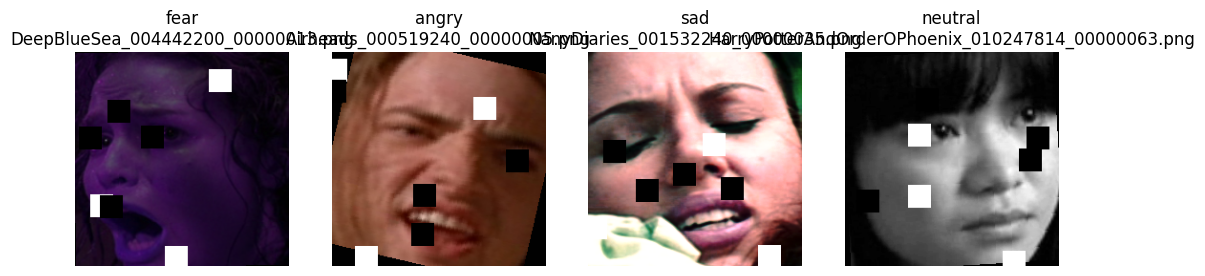

In [132]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [133]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Performance Metrics

In [134]:
#TODO: Move to Utils

labels_map={0:"Angry",
            1:"Disgust",
            2:"Fear",
            3:"Happy",
            4:"Sad",
            5:"Surprise",
            6:"Neutral"}

def performance_metric(model,
                       device,
                       data_loader):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images*255)) # forward pass, output = {class}
          true_labels.extend(labels.argmax(dim=1).cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())
    # print(f'true labels - {true_labels}')
    # print(f'predicted labels - {predicted_labels}')

    true_labels = [labels_map[int_label] for int_label in true_labels]
    predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_names = list(labels_map.values())
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report



## Model Initialization

### Simple Model_V9_SE
- including dann
- including grl
- including SE - muliple places, after maxpool


In [153]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [154]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [155]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [156]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        # self.se_block = SEBlock(512)
        list_feature_extractor.insert(-15,  SEBlock(256))
        list_feature_extractor.insert(-8,  SEBlock(512))
        list_feature_extractor.insert(-1,  SEBlock(512))
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [157]:
model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)
from torchsummary import summary  #for model summary and params
print(model)

DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

In [158]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [159]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# !pip install torch-summary

In [ ]:
# from torchsummary import summary
# summary(model, (3, 224, 224), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose =2 )

## Checking accuracy before fine tuning

In [160]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [161]:
model = model.to(device=device)

### Test Function

In [162]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [163]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

#### Pre fine train metric

In [164]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.1618, Accuracy: 98/419 (23.39%)



(98, 0.16177522083455453)

In [165]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.23389021479713604
Precision: 0.33327642926614887
Confusion Matrix:
[[ 4 10  0  6 33 20  2]
 [ 0  4  0  4  9  3  2]
 [ 3  7  1  4 13 13  2]
 [ 0  3  0 48 14  7  0]
 [ 0  6  1  3 27  8  7]
 [ 1  7  0  5 63  7  1]
 [ 0  1  1  2 19 41  7]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry         4       10     0      6   33        20        2
Disgust       0        4     0      4    9         3        2
Fear          3        7     1      4   13        13        2
Happy         0        3     0     48   14         7        0
Sad           0        6     1      3   27         8        7
Surprise      1        7     0      5   63         7        1
Neutral       0        1     1      2   19        41        7
Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.05      0.10        75
     Disgust       0.11      0.18      0.13        22
        Fear       0.33      0.02      0.04        43
       Happy    

### Train Function

#### Basic Training Function

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()
    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs,_,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset: .2f} %')

    return



#### Training Function with LR Scheduler

In [166]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


In [167]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Execution without Learning Rate

In [ ]:
# num_epochs=55
# for epoch in range(num_epochs):
#   train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
#   test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')
# print('Training finished.')

### Execution with LR

In [168]:
runconfig = RunConfig()
device = runconfig.device

model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)
best_model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)

#learning rate
lr =  0.001 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 2 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  150
epoch = 1...in training function


  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss=2.0214080810546875 Accuracy=160/913(17.52%) Epoch Avg loss=0.13054853 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.66it/s]


Test / Val: Average loss: 0.1259, Accuracy: 60/419 (14.32%)

last correct =60 | best correct = 0
Updated the best model with correct: 60



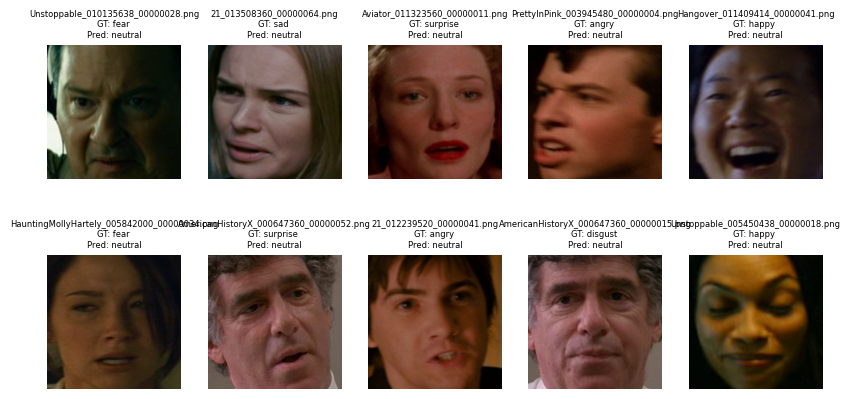

EPOCH: 2  of  150
epoch = 2...in training function


Loss=2.1323909759521484 Accuracy=167/913(18.29%) Epoch Avg loss=0.12518437 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.1248, Accuracy: 84/419 (20.05%)

last correct =84 | best correct = 60
Updated the best model with correct: 84

EPOCH: 3  of  150
epoch = 3...in training function


Loss=2.087254285812378 Accuracy=164/913(17.96%) Epoch Avg loss=0.12276228 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Test / Val: Average loss: 0.1240, Accuracy: 84/419 (20.05%)

last correct =84 | best correct = 84
EPOCH: 4  of  150
epoch = 4...in training function


Loss=1.6086379289627075 Accuracy=162/913(17.74%) Epoch Avg loss=0.12023051 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]


Test / Val: Average loss: 0.1224, Accuracy: 77/419 (18.38%)

last correct =77 | best correct = 84
EPOCH: 5  of  150
epoch = 5...in training function


Loss=1.0751739740371704 Accuracy=165/913(18.07%) Epoch Avg loss=0.11999396 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


Test / Val: Average loss: 0.1217, Accuracy: 82/419 (19.57%)

last correct =82 | best correct = 84
EPOCH: 6  of  150
epoch = 6...in training function


Loss=1.8923512697219849 Accuracy=184/913(20.15%) Epoch Avg loss=0.12028827 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.1222, Accuracy: 80/419 (19.09%)

last correct =80 | best correct = 84
EPOCH: 7  of  150
epoch = 7...in training function


Loss=1.2677373886108398 Accuracy=216/913(23.66%) Epoch Avg loss=0.11874214 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]


Test / Val: Average loss: 0.1206, Accuracy: 95/419 (22.67%)

last correct =95 | best correct = 84
Updated the best model with correct: 95

EPOCH: 8  of  150
epoch = 8...in training function


Loss=1.9465694427490234 Accuracy=209/913(22.89%) Epoch Avg loss=0.11777826 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.1184, Accuracy: 103/419 (24.58%)

last correct =103 | best correct = 95
Updated the best model with correct: 103

EPOCH: 9  of  150
epoch = 9...in training function


Loss=1.6456518173217773 Accuracy=225/913(24.64%) Epoch Avg loss=0.11632343 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


Test / Val: Average loss: 0.1146, Accuracy: 148/419 (35.32%)

last correct =148 | best correct = 103
Updated the best model with correct: 148

EPOCH: 10  of  150
epoch = 10...in training function


Loss=2.068183660507202 Accuracy=296/913(32.42%) Epoch Avg loss=0.11081213 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.53it/s]


Test / Val: Average loss: 0.1095, Accuracy: 151/419 (36.04%)

last correct =151 | best correct = 148
Updated the best model with correct: 151

EPOCH: 11  of  150
epoch = 11...in training function


Loss=1.7782952785491943 Accuracy=327/913(35.82%) Epoch Avg loss=0.10500202 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


Test / Val: Average loss: 0.1073, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 151
Updated the best model with correct: 178



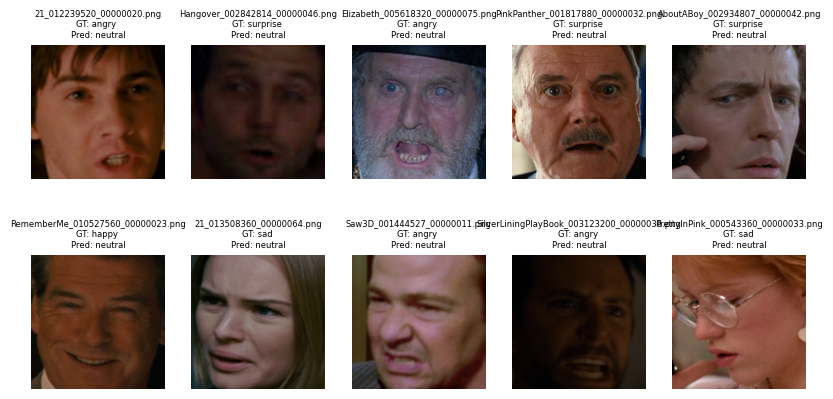

EPOCH: 12  of  150
epoch = 12...in training function


Loss=0.714698314666748 Accuracy=376/913(41.18%) Epoch Avg loss=0.09833330 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]


Test / Val: Average loss: 0.1027, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 178
Updated the best model with correct: 181

EPOCH: 13  of  150
epoch = 13...in training function


Loss=1.5429768562316895 Accuracy=384/913(42.06%) Epoch Avg loss=0.09617800 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]


Test / Val: Average loss: 0.1085, Accuracy: 169/419 (40.33%)

last correct =169 | best correct = 181
EPOCH: 14  of  150
epoch = 14...in training function


Loss=1.4177106618881226 Accuracy=410/913(44.91%) Epoch Avg loss=0.09230266 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.55it/s]


Test / Val: Average loss: 0.1010, Accuracy: 201/419 (47.97%)

last correct =201 | best correct = 181
Updated the best model with correct: 201

EPOCH: 15  of  150
epoch = 15...in training function


Loss=1.5398032665252686 Accuracy=455/913(49.84%) Epoch Avg loss=0.08835535 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Test / Val: Average loss: 0.0948, Accuracy: 205/419 (48.93%)

last correct =205 | best correct = 201
Updated the best model with correct: 205

EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.3524761497974396 Accuracy=477/913(52.25%) Epoch Avg loss=0.08318220 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]


Test / Val: Average loss: 0.1040, Accuracy: 182/419 (43.44%)

last correct =182 | best correct = 205
EPOCH: 17  of  150
epoch = 17...in training function


Loss=0.3902778625488281 Accuracy=538/913(58.93%) Epoch Avg loss=0.07613440 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Test / Val: Average loss: 0.0980, Accuracy: 211/419 (50.36%)

last correct =211 | best correct = 205
Updated the best model with correct: 211

EPOCH: 18  of  150
epoch = 18...in training function


Loss=0.4515329599380493 Accuracy=539/913(59.04%) Epoch Avg loss=0.07275433 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Test / Val: Average loss: 0.0985, Accuracy: 202/419 (48.21%)

last correct =202 | best correct = 211
EPOCH: 19  of  150
epoch = 19...in training function


Loss=1.5039186477661133 Accuracy=562/913(61.56%) Epoch Avg loss=0.06763028 LR=0.001000: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]


Test / Val: Average loss: 0.0944, Accuracy: 215/419 (51.31%)

last correct =215 | best correct = 211
Updated the best model with correct: 215

EPOCH: 20  of  150
epoch = 20...in training function


Loss=0.879448652267456 Accuracy=574/913(62.87%) Epoch Avg loss=0.06579903 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.0980, Accuracy: 206/419 (49.16%)

last correct =206 | best correct = 215
EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.05656022951006889 Accuracy=574/913(62.87%) Epoch Avg loss=0.06522118 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.57it/s]


Test / Val: Average loss: 0.0944, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 215
Updated the best model with correct: 222



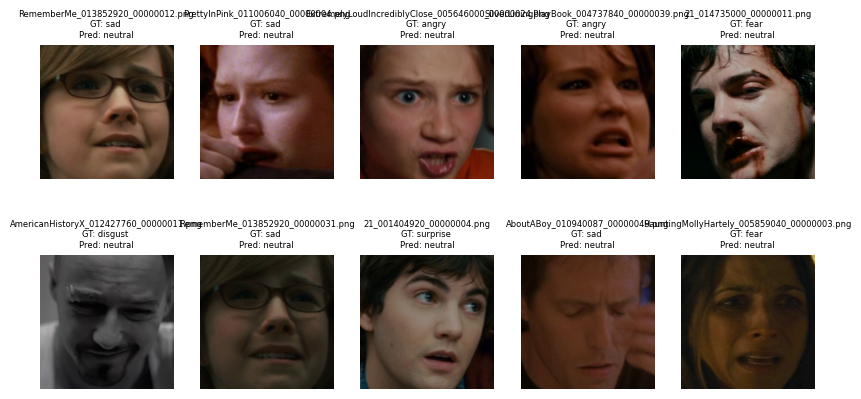

EPOCH: 22  of  150
epoch = 22...in training function


Loss=8.147461891174316 Accuracy=597/913(65.39%) Epoch Avg loss=0.06995269 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.53it/s]


Test / Val: Average loss: 0.0987, Accuracy: 209/419 (49.88%)

last correct =209 | best correct = 222
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.4151208698749542 Accuracy=543/913(59.47%) Epoch Avg loss=0.07491579 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]


Test / Val: Average loss: 0.1124, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 222
EPOCH: 24  of  150
epoch = 24...in training function


Loss=1.3407142162322998 Accuracy=592/913(64.84%) Epoch Avg loss=0.06246082 LR=0.001000: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.0993, Accuracy: 207/419 (49.40%)

last correct =207 | best correct = 222
EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.9056897759437561 Accuracy=662/913(72.51%) Epoch Avg loss=0.05204142 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Test / Val: Average loss: 0.0947, Accuracy: 221/419 (52.74%)

last correct =221 | best correct = 222
EPOCH: 26  of  150
epoch = 26...in training function


Loss=0.39235103130340576 Accuracy=691/913(75.68%) Epoch Avg loss=0.04403621 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


Test / Val: Average loss: 0.1089, Accuracy: 223/419 (53.22%)

last correct =223 | best correct = 222
Updated the best model with correct: 223

EPOCH: 27  of  150
epoch = 27...in training function


Loss=0.2466174215078354 Accuracy=711/913(77.88%) Epoch Avg loss=0.04078146 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


Test / Val: Average loss: 0.1017, Accuracy: 213/419 (50.84%)

last correct =213 | best correct = 223
EPOCH: 28  of  150
epoch = 28...in training function


Loss=0.0003057250869460404 Accuracy=728/913(79.74%) Epoch Avg loss=0.03612551 LR=0.000200: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


Test / Val: Average loss: 0.1009, Accuracy: 229/419 (54.65%)

last correct =229 | best correct = 223
Updated the best model with correct: 229

EPOCH: 29  of  150
epoch = 29...in training function


Loss=0.43591898679733276 Accuracy=738/913(80.83%) Epoch Avg loss=0.03387837 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.55it/s]


Test / Val: Average loss: 0.1146, Accuracy: 217/419 (51.79%)

last correct =217 | best correct = 229
EPOCH: 30  of  150
epoch = 30...in training function


Loss=0.7166949510574341 Accuracy=744/913(81.49%) Epoch Avg loss=0.03477745 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]


Test / Val: Average loss: 0.1084, Accuracy: 223/419 (53.22%)

last correct =223 | best correct = 229
EPOCH: 31  of  150
epoch = 31...in training function


Loss=3.194758028257638e-05 Accuracy=753/913(82.48%) Epoch Avg loss=0.03262101 LR=0.000200: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]


Test / Val: Average loss: 0.1123, Accuracy: 221/419 (52.74%)

last correct =221 | best correct = 229


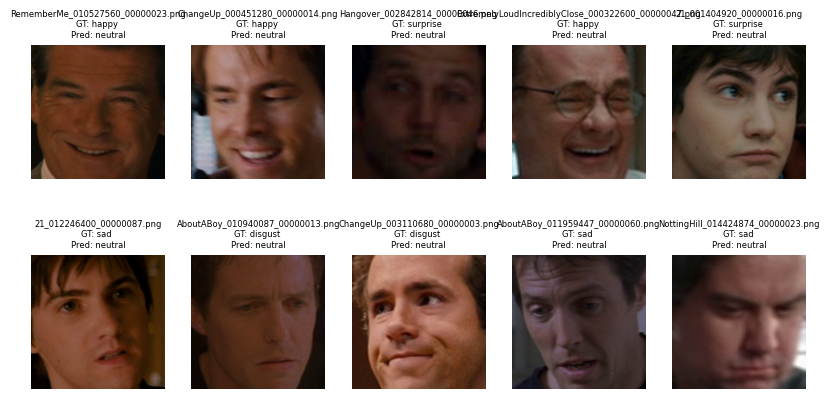

EPOCH: 32  of  150
epoch = 32...in training function


Loss=1.0967194612021558e-05 Accuracy=762/913(83.46%) Epoch Avg loss=0.02914071 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


Test / Val: Average loss: 0.1058, Accuracy: 230/419 (54.89%)

last correct =230 | best correct = 229
Updated the best model with correct: 230

EPOCH: 33  of  150
epoch = 33...in training function


Loss=0.8873376846313477 Accuracy=789/913(86.42%) Epoch Avg loss=0.02701238 LR=0.000200: 100%|██████████| 58/58 [00:22<00:00,  2.53it/s]


Test / Val: Average loss: 0.1145, Accuracy: 218/419 (52.03%)

last correct =218 | best correct = 230
EPOCH: 34  of  150
epoch = 34...in training function


Loss=0.02417014166712761 Accuracy=788/913(86.31%) Epoch Avg loss=0.02740618 LR=0.000040: 100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Test / Val: Average loss: 0.1132, Accuracy: 229/419 (54.65%)

last correct =229 | best correct = 230
EPOCH: 35  of  150
epoch = 35...in training function


Loss=0.00023993951617740095 Accuracy=811/913(88.83%) Epoch Avg loss=0.02282108 LR=0.000040: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


Test / Val: Average loss: 0.1108, Accuracy: 232/419 (55.37%)

last correct =232 | best correct = 230
Updated the best model with correct: 232

EPOCH: 36  of  150
epoch = 36...in training function


Loss=5.5549986427649856e-05 Accuracy=804/913(88.06%) Epoch Avg loss=0.02365718 LR=0.000040: 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Test / Val: Average loss: 0.1180, Accuracy: 228/419 (54.42%)

last correct =228 | best correct = 232
EPOCH: 37  of  150
epoch = 37...in training function


Loss=1.4035377502441406 Accuracy=786/913(86.09%) Epoch Avg loss=0.02490360 LR=0.000040: 100%|██████████| 58/58 [00:22<00:00,  2.58it/s]


Test / Val: Average loss: 0.1152, Accuracy: 227/419 (54.18%)

last correct =227 | best correct = 232
EPOCH: 38  of  150
epoch = 38...in training function


Loss=2.861018856492592e-06 Accuracy=804/913(88.06%) Epoch Avg loss=0.02229020 LR=0.000040: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


Test / Val: Average loss: 0.1195, Accuracy: 228/419 (54.42%)

last correct =228 | best correct = 232
-------Early Stopping at epoch 38---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1103, Accuracy: 232/419 (55.37%)



In [169]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model_local(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)


dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


### Validation on Test Dataset - only when data loader is avaialable



In [ ]:
test_model_local(model= best_model,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = runconfig.criterion_class)

### `Model Performance Metrics`

In [171]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


Accuracy: 0.5536992840095465
Precision: 0.5529220507056362
Confusion Matrix:
[[40 16  0  4  8  5  2]
 [ 1  1  1  6  3  6  4]
 [ 8  2 12  3  3  7  8]
 [ 2  0  0 62  1  3  4]
 [ 9  0  2  5 23 10  3]
 [ 5  5  1  1  6 62  4]
 [ 3  1  6  2 12 15 32]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        40       16     0      4    8         5        2
Disgust       1        1     1      6    3         6        4
Fear          8        2    12      3    3         7        8
Happy         2        0     0     62    1         3        4
Sad           9        0     2      5   23        10        3
Surprise      5        5     1      1    6        62        4
Neutral       3        1     6      2   12        15       32
Classification Report:
              precision    recall  f1-score   support

       Angry       0.59      0.53      0.56        75
     Disgust       0.04      0.05      0.04        22
        Fear       0.55      0.28      0.37        43
       Happy      

### Saving Non-Dann Model

In [172]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [173]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
print("\nDO VERIFY THE MODEL NAME BEFORE MOVING AHEAD: ", model_name)


DO VERIFY THE MODEL NAME BEFORE MOVING AHEAD:  non_dann_sfew_expw_14_04_se.pt


In [174]:
# model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_{se}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [175]:
model_name

'non_dann_sfew_expw_14_04_se.pt'

## Dataset - Target

- EXPW dataset

In [176]:
# checking the mounted drive and mounting if not done
import os
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")


Google Drive is already mounted.


### Creating Dataloader for EXPW

In [177]:
from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE

expw_obj = EXPWCROPRACE()

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:45<00:00, 78.3MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
train list [('awe_African_936.jpg', 3), ('amazed_president_502.jpg', 3)] <class 'list'> 1000
size of dataset (list_img_label): 1000
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
15 were not able to crop
985 cropped images created in cropped
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDriv

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [179]:
if expw_train_loader is None:
  sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
  data_loader = {'source' : sfew_loader}
  source_name = data_loader['source']['name']
  target_name = "expw"
else:
  sfew_loader = {'name': 'sfew',
                'train':sfew_train_loader,
                'val':sfew_val_loader
                }

  expw_loader = {'name': 'expw',
                'train':expw_train_loader,
                'val':expw_val_loader
                }

  data_loader = {'source' : sfew_loader,
                'target' : expw_loader}

  source_name = data_loader['source']['name']
  target_name = data_loader['target']['name']

## Loading NON DANN Model for DANN and DANN EWC


In [181]:
# source_name = "sfew"
# target_name = "expw"
today_model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
print(f'today_model_name {today_model_name}')
custom_model_name= 'non_dann_sfew_expw_08_04.pt'
print(f'custom_model_name {custom_model_name}')

model_name = today_model_name

print("\n****model name that would be used for loading: ", model_name)

today_model_name non_dann_sfew_expw_14_04_se.pt
custom_model_name non_dann_sfew_expw_08_04.pt

****model name that would be used for loading:  non_dann_sfew_expw_14_04_se.pt


### Loading Structure of Models

In [183]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        # self.se_block = SEBlock(512)
        list_feature_extractor.insert(-15,  SEBlock(256))
        list_feature_extractor.insert(-8,  SEBlock(512))
        list_feature_extractor.insert(-1,  SEBlock(512))
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features



In [184]:
if not device:
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

In [185]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

model_dann =  DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

model_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

model_dann_ewc = deepcopy(model_dann) # saves training time - check with all

# print(model_dann)

In [186]:
model_dann

DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

In [187]:
params = {name: param for name, param in model_dann.named_parameters() if param.requires_grad}
params.keys()

dict_keys(['feature_extractor.0.weight', 'feature_extractor.0.bias', 'feature_extractor.2.weight', 'feature_extractor.2.bias', 'feature_extractor.5.weight', 'feature_extractor.5.bias', 'feature_extractor.7.weight', 'feature_extractor.7.bias', 'feature_extractor.10.weight', 'feature_extractor.10.bias', 'feature_extractor.12.weight', 'feature_extractor.12.bias', 'feature_extractor.14.weight', 'feature_extractor.14.bias', 'feature_extractor.17.fc.0.weight', 'feature_extractor.17.fc.0.bias', 'feature_extractor.17.fc.2.weight', 'feature_extractor.17.fc.2.bias', 'feature_extractor.18.weight', 'feature_extractor.18.bias', 'feature_extractor.20.weight', 'feature_extractor.20.bias', 'feature_extractor.22.weight', 'feature_extractor.22.bias', 'feature_extractor.25.fc.0.weight', 'feature_extractor.25.fc.0.bias', 'feature_extractor.25.fc.2.weight', 'feature_extractor.25.fc.2.bias', 'feature_extractor.26.weight', 'feature_extractor.26.bias', 'feature_extractor.28.weight', 'feature_extractor.28.bias

## Test Function

In [188]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

## DANN Execution: Training, Validating, Saving

### DANN Execution Function

In [189]:
def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [190]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
lr_dann = 0.001 # override
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)



EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### DANN Execution

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch[1/150] Step[1/58]: loss_total=1.7082 / domain_loss_target=0.7055 / domain_loss_source=0.6706 / task_loss=0.3320 / domain_loss=1.0027 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[11/58]: loss_total=2.2836 / domain_loss_target=0.6126 / domain_loss_source=0.7170 / task_loss=0.9540 / domain_loss=1.6710 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[21/58]: loss_total=1.7879 / domain_loss_target=0.6257 / domain_loss_source=0.7317 / task_loss=0.4305 / domain_loss=1.1622 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[31/58]: loss_total=1.9702 / domain_loss_target=0.6711 / domain_loss_source=0.7071 / task_loss=0.5919 / domain_loss=1.2991 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[41/58]: loss_total=2.1760 / domain_loss_target=0.5742 / domain_loss_source=0.7110 / task_loss=0.8908 / domain_loss=1.6019 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[51/58]: loss_total=2.1847 / domain_loss_target=0.6569 / domain_loss_source=0.7261 / task_loss=0.8016 / domain_loss=1.5277 / alpha=1.00 / lr=0.001000

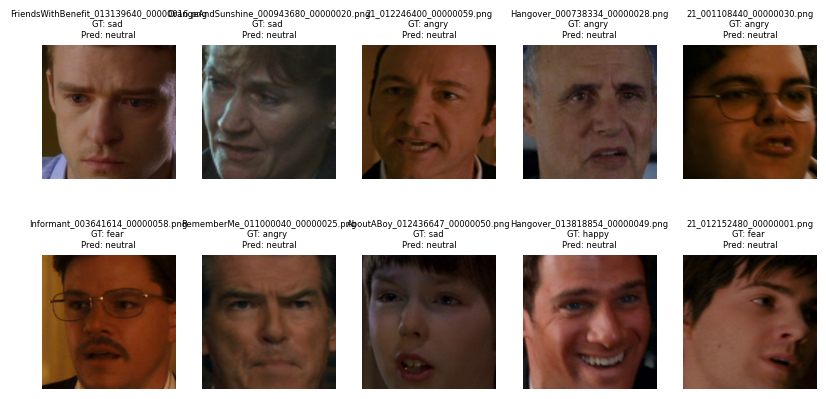

epoch = 2...in DANN execution function


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch[2/150] Step[1/58]: loss_total=1.9673 / domain_loss_target=0.6820 / domain_loss_source=0.6739 / task_loss=0.6114 / domain_loss=1.2853 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[11/58]: loss_total=2.1091 / domain_loss_target=0.7264 / domain_loss_source=0.6521 / task_loss=0.7306 / domain_loss=1.3828 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[21/58]: loss_total=2.0868 / domain_loss_target=0.7551 / domain_loss_source=0.6043 / task_loss=0.7273 / domain_loss=1.3316 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[31/58]: loss_total=2.2856 / domain_loss_target=0.6587 / domain_loss_source=0.7239 / task_loss=0.9030 / domain_loss=1.6269 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[41/58]: loss_total=1.8444 / domain_loss_target=0.6750 / domain_loss_source=0.7201 / task_loss=0.4494 / domain_loss=1.1695 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[51/58]: loss_total=2.1365 / domain_loss_target=0.6683 / domain_loss_source=0.7392 / task_loss=0.7291 / domain_loss=1.4683 / alpha=1.00 / lr=0.001000

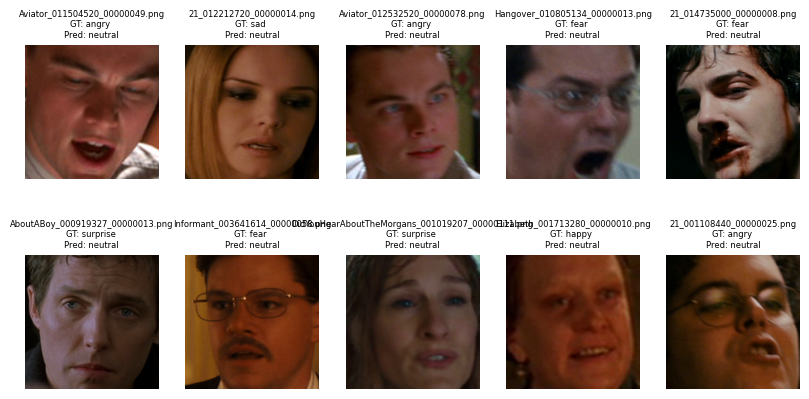

epoch = 12...in DANN execution function
Epoch[12/150] Step[1/58]: loss_total=1.9544 / domain_loss_target=0.6625 / domain_loss_source=0.5998 / task_loss=0.6921 / domain_loss=1.2919 / alpha=1.00 / lr=0.001000
Epoch[12/150] Step[11/58]: loss_total=1.7048 / domain_loss_target=0.8515 / domain_loss_source=0.5396 / task_loss=0.3137 / domain_loss=0.8533 / alpha=1.00 / lr=0.001000
Epoch[12/150] Step[21/58]: loss_total=2.1727 / domain_loss_target=0.7468 / domain_loss_source=0.6385 / task_loss=0.7873 / domain_loss=1.4258 / alpha=1.00 / lr=0.001000
Epoch[12/150] Step[31/58]: loss_total=2.1985 / domain_loss_target=0.6568 / domain_loss_source=0.7288 / task_loss=0.8128 / domain_loss=1.5416 / alpha=1.00 / lr=0.001000
Epoch[12/150] Step[41/58]: loss_total=1.7956 / domain_loss_target=0.5725 / domain_loss_source=0.7314 / task_loss=0.4917 / domain_loss=1.2231 / alpha=1.00 / lr=0.001000
Epoch[12/150] Step[51/58]: loss_total=2.0922 / domain_loss_target=0.5965 / domain_loss_source=0.7833 / task_loss=0.7123 /

In [191]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

### DANN Saving

In [192]:
dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(dann_model_trained.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_sfew_expw_14_04_se.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_14_04_se.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_14_04_se.pt!


### DANN Performance

In [193]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


Accuracy: 0.5704057279236276
Precision: 0.5653489531519682
Confusion Matrix:
[[39  2  0 15  6  8  5]
 [ 0  1  1  2  2  7  9]
 [ 5  0  4  6  6  6 16]
 [ 0  0  0 63  0  3  6]
 [ 5  0  1  4 17 19  6]
 [ 0  0  1  3  1 66 13]
 [ 2  0  1  4  5 10 49]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        39        2     0     15    6         8        5
Disgust       0        1     1      2    2         7        9
Fear          5        0     4      6    6         6       16
Happy         0        0     0     63    0         3        6
Sad           5        0     1      4   17        19        6
Surprise      0        0     1      3    1        66       13
Neutral       2        0     1      4    5        10       49
Classification Report:
              precision    recall  f1-score   support

       Angry       0.76      0.52      0.62        75
     Disgust       0.33      0.05      0.08        22
        Fear       0.50      0.09      0.16        43
       Happy      

## EWC DANN Execution: Training, Validating, Saving


In [194]:
model_dann_ewc


DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

### EWC Code
- Regularization Penalty

In [195]:
from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        # for n, p in deepcopy(self.params).items():
        for n, p in self.params.items():

            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            batch[0] = batch[0]* 255.0
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = self.model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execution Function

In [196]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(existing_model.to(device),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)


            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx +1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    # print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses



### EWC DANN Execution Config

In [197]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
lr_ewc_dann = 0.001 #override

optimizer_ewc_dann = optim.SGD(model_dann_ewc.parameters(), lr = lr_ewc_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override
# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)


EPOCHS 150
0.4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### EWC DANN Execution

In [198]:
print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model= model_dann_ewc,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = scheduler,
                                                          early_stop_patience = early_stop_patience,
                                                          early_stop_difference = early_stop_difference
                                                         )

------------training started for EWC DANN Model ------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 291.06 MiB is free. Process 14282 has 14.46 GiB memory in use. Of the allocated memory 12.52 GiB is allocated by PyTorch, and 1.78 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### EWC DANN Saving

In [ ]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))



if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')

### EWC DANN Performance

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= ewc_dann_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )